In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_dataset_paths(dataset_name="eval15"):
    base_path= f"lol_dataset/{dataset_name}"
    low_path = os.path.join(base_path,"low")
    high_path = os.path.join(base_path,"high")

    return low_path, high_path

In [39]:
def gamma_correction(img, gamma=1.2):
    """
    Apply gamma correction to brighten the image while preserving color.
    """
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    corrected_img = cv2.LUT(img, table)
    return corrected_img

def color_transfer(source_img, target_img):
    """
    Transfers the color of the target image to the source image.
    
    Args:
    - source_img (numpy.ndarray): The low-light image to be enhanced.
    - target_img (numpy.ndarray): The high-quality reference image.
    
    Returns:
    - result (numpy.ndarray): The color-preserved enhanced image.
    """
    # Convert both images to Lab color space
    source_lab = cv2.cvtColor(source_img, cv2.COLOR_BGR2Lab)
    target_lab = cv2.cvtColor(target_img, cv2.COLOR_BGR2Lab)
    
    # Split into L, a, b channels
    l_source, a_source, b_source = cv2.split(source_lab)
    l_target, a_target, b_target = cv2.split(target_lab)
    
    
    # Resize target channels to match the source channels' size 
    if l_source.shape != l_target.shape:
        target_img = cv2.resize(target_img, (l_source.shape[1], l_source.shape[0]))
        target_lab = cv2.cvtColor(target_img, cv2.COLOR_BGR2Lab)
        l_target, a_target, b_target = cv2.split(target_lab)
    
    # Apply the color transfer by matching means and standard deviations
    l_source = l_source.astype("float32")
    a_source = a_source.astype("float32")
    b_source = b_source.astype("float32")
    
    l_target = l_target.astype("float32")
    a_target = a_target.astype("float32")
    b_target = b_target.astype("float32")
    
    # Match L channel (luminance)
    l_source = (l_source - np.mean(l_source)) * (np.std(l_target) / np.std(l_source)) + np.mean(l_target)
    
    # Match a and b channels (color)
    a_source = (a_source - np.mean(a_source)) * (np.std(a_target) / np.std(a_source)) + np.mean(a_target)
    b_source = (b_source - np.mean(b_source)) * (np.std(b_target) / np.std(b_source)) + np.mean(b_target)
    
    # Clip the values to valid range
    l_source = np.clip(l_source, 0, 255).astype("uint8")
    a_source = np.clip(a_source, 0, 255).astype("uint8")
    b_source = np.clip(b_source, 0, 255).astype("uint8")
    
    # Merge the channels back together
    result_lab = cv2.merge([l_source, a_source, b_source])
    
    # Convert back to BGR color space
    result = cv2.cvtColor(result_lab, cv2.COLOR_Lab2BGR)
    
    return result


def enhance_image_color_preserving(low_img, high_img):
    """
    Enhances the low-light image while preserving color using gamma correction and color transfer.
    """
    gamma_enhanced_img = gamma_correction(low_img, gamma=1.2)
    enhanced_img = color_transfer(gamma_enhanced_img, high_img)
    return enhanced_img


In [40]:
def show_comparison(low_img, enhanced_img, high_img, title="Comparison"):
    """
    Displays a comparison of low-light, enhanced, and high-quality images.
    """
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB))
    plt.title("Low Light Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
    plt.title("Enhanced Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB))
    plt.title("High Quality Image")
    plt.axis("off")
    
    plt.suptitle(title, fontsize=16)
    plt.show()


In [41]:
def resize_images_to_match(low_img, high_img):
    """
    Resizes the images to have the same dimensions.
    
    Args:
    - low_img (numpy.ndarray): Low-light image.
    - high_img (numpy.ndarray): High-quality image.
    
    Returns:
    - low_img_resized (numpy.ndarray): Resized low-light image.
    - high_img_resized (numpy.ndarray): Resized high-quality image.
    """
    if low_img.shape != high_img.shape:
        high_img_resized = cv2.resize(high_img, (low_img.shape[1], low_img.shape[0]))
        return low_img, high_img_resized
    return low_img, high_img


Found 15 matched image pairs.


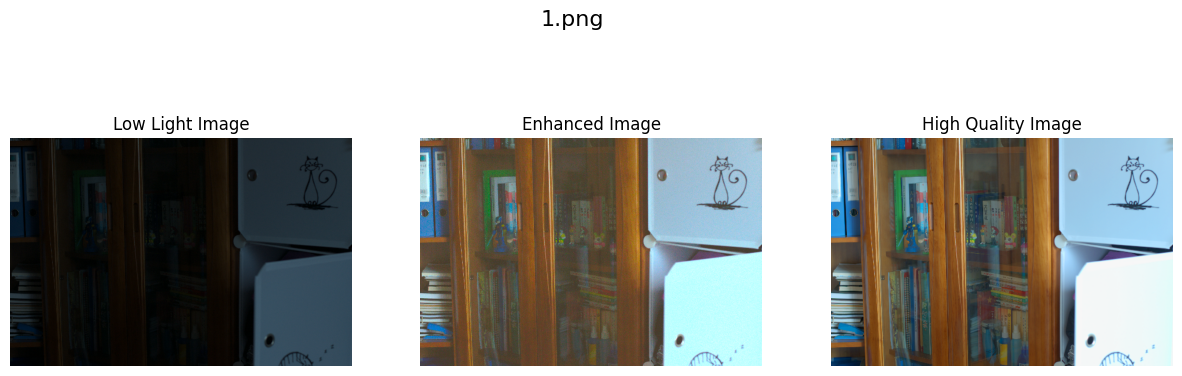

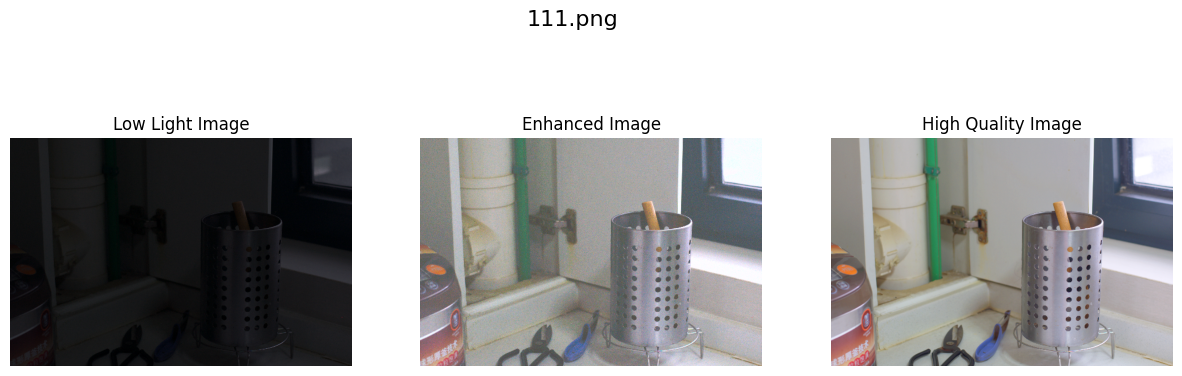

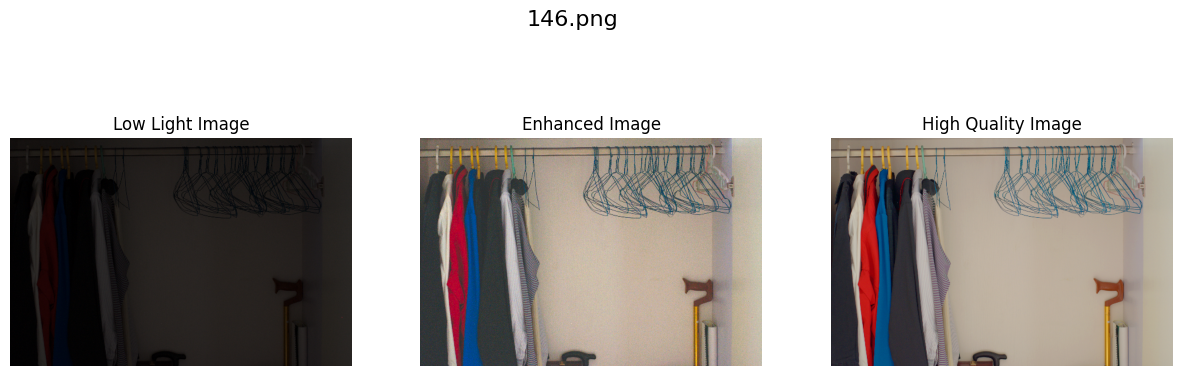

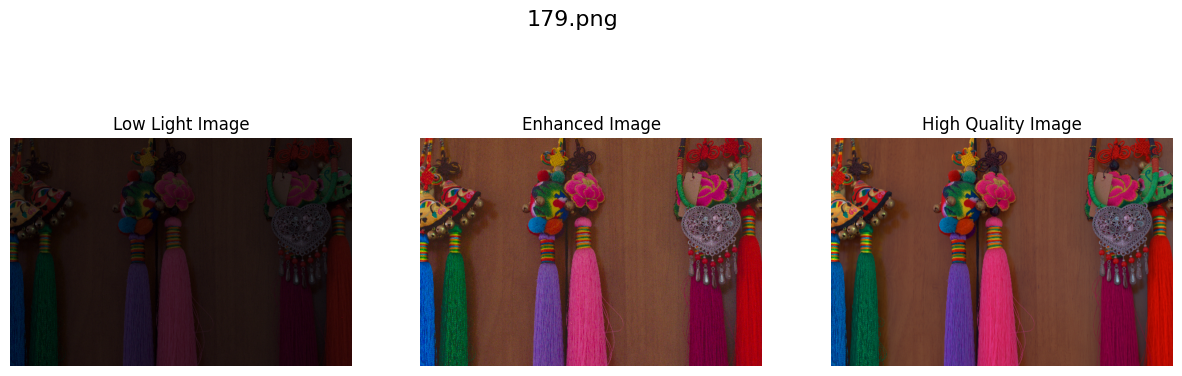

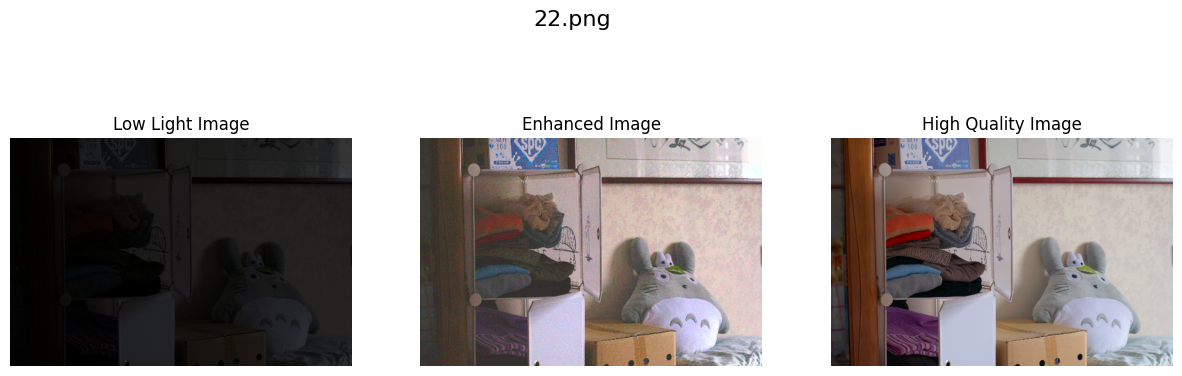

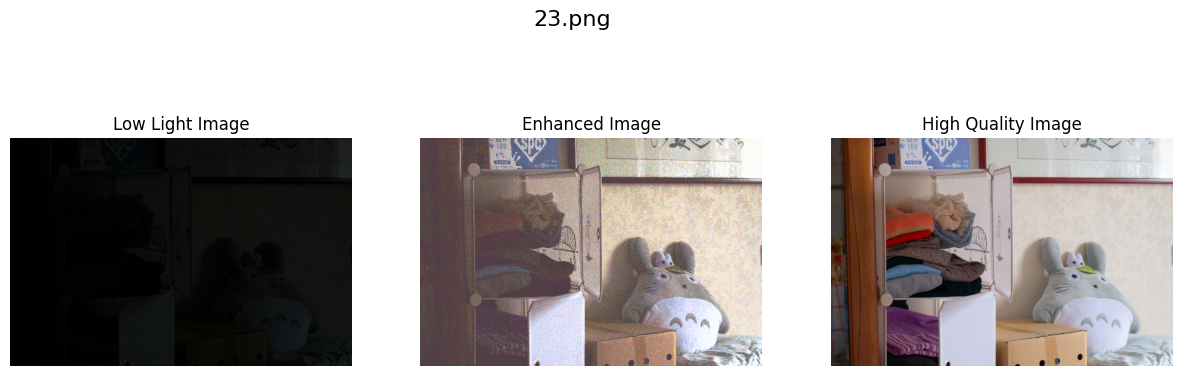

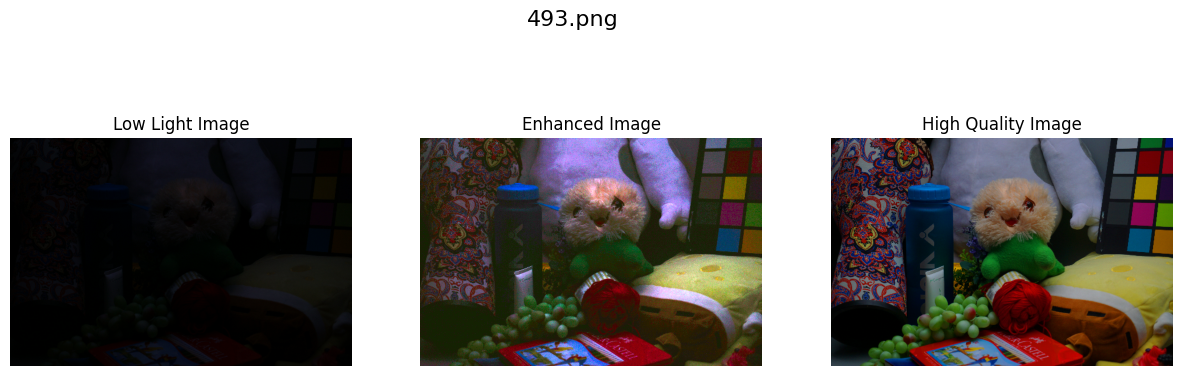

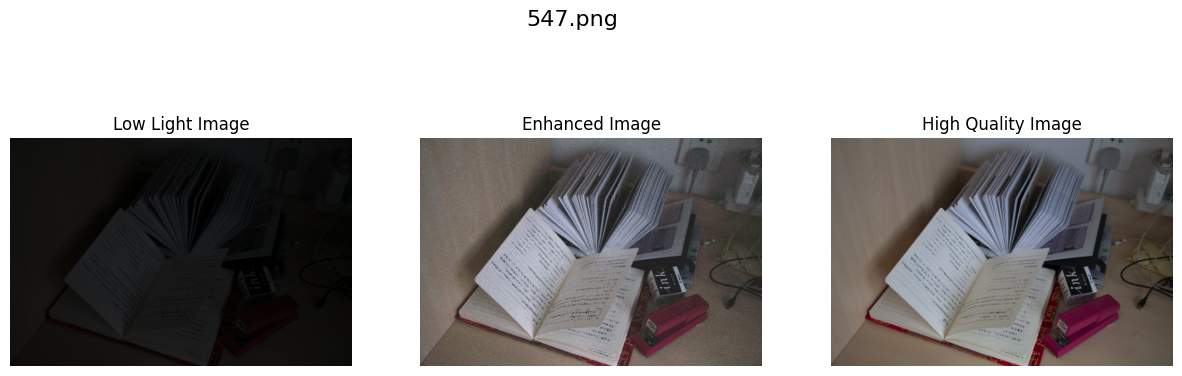

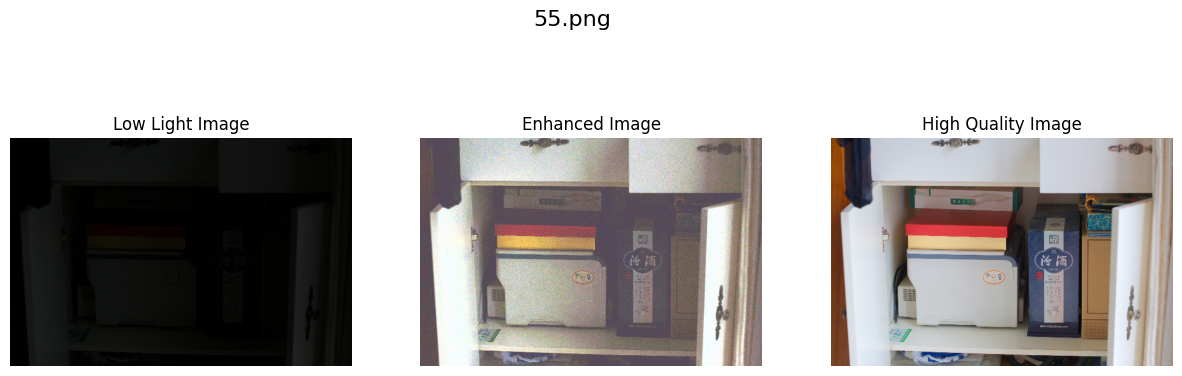

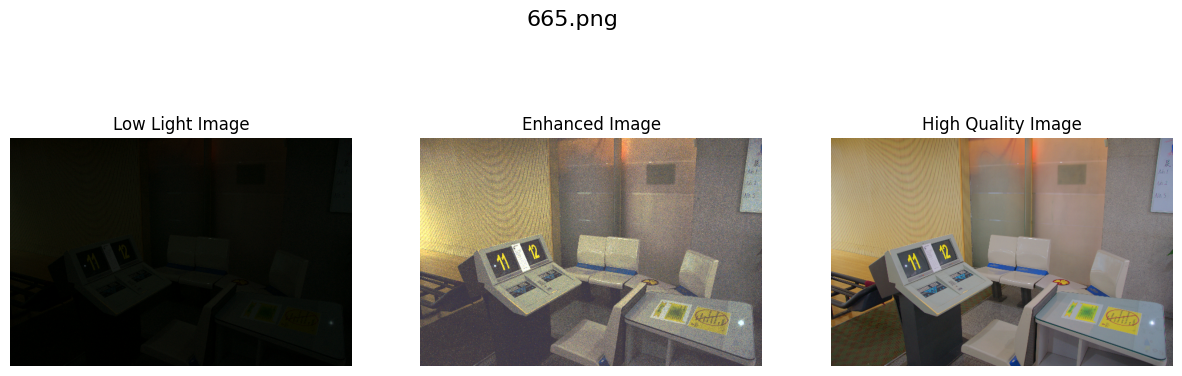

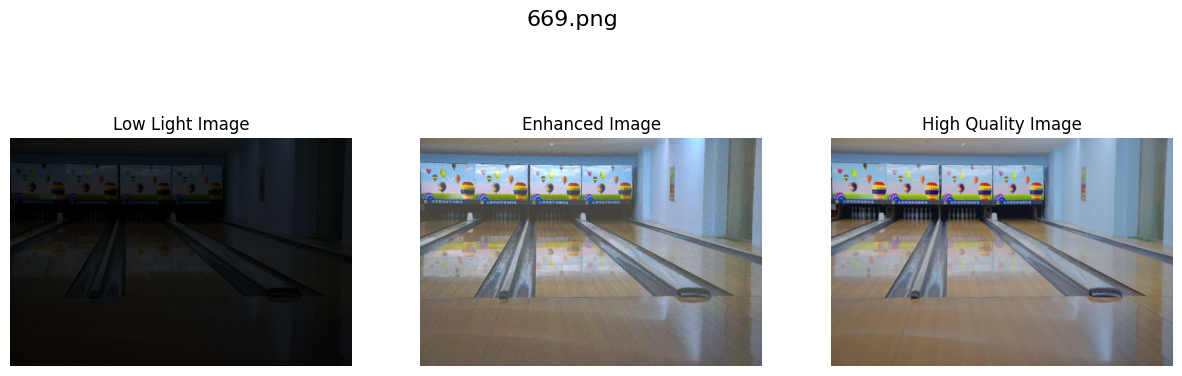

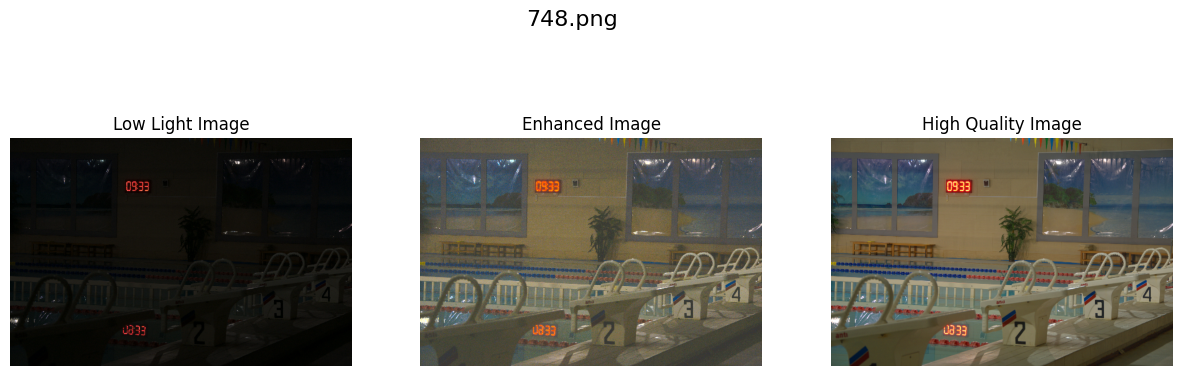

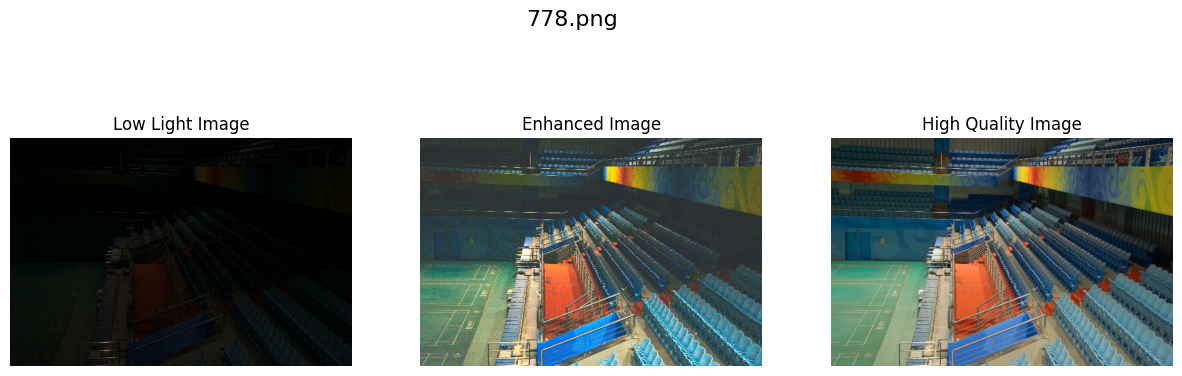

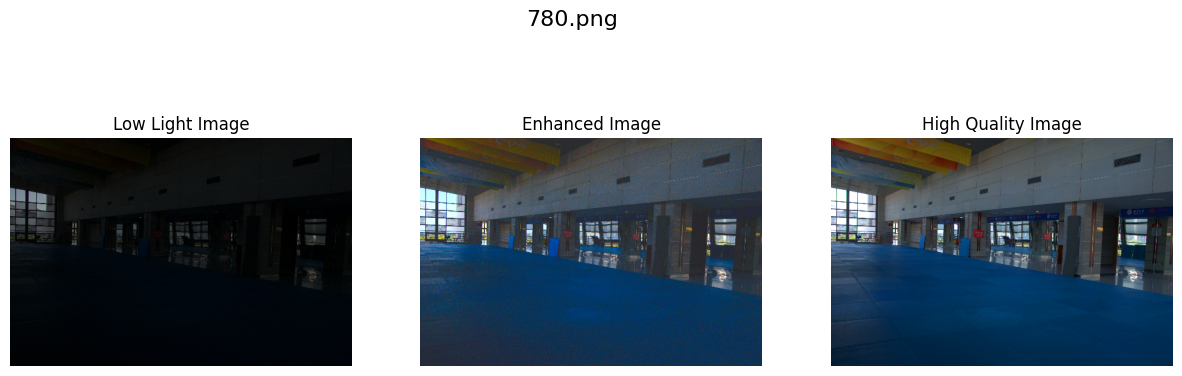

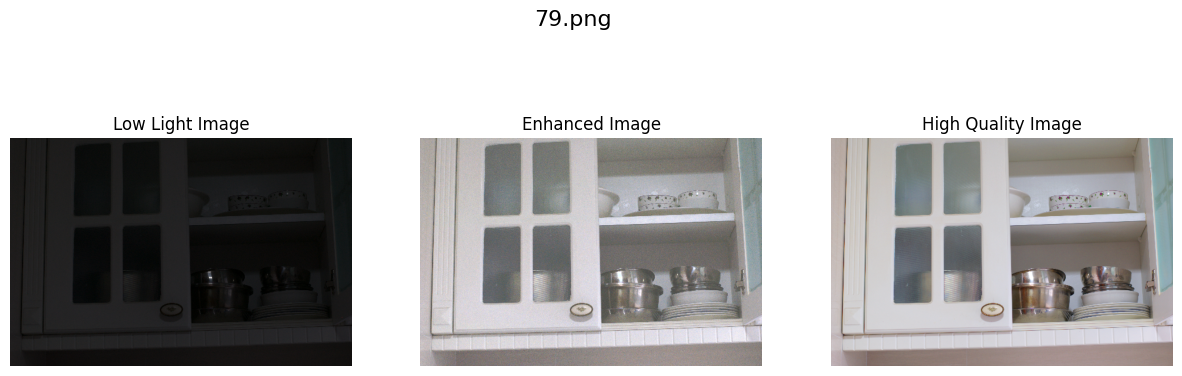

In [42]:
dataset_name = "eval15"  # or "our485"
low_path, high_path = get_dataset_paths(dataset_name)

# Get filenames that exist in BOTH low and high folders
low_filenames = set(os.listdir(low_path))
high_filenames = set(os.listdir(high_path))
test_filenames = sorted(list(low_filenames & high_filenames))

print(f"Found {len(test_filenames)} matched image pairs.")

for filename in test_filenames:
    
    low_img = cv2.imread(os.path.join(low_path, filename))
    high_img = cv2.imread(os.path.join(high_path, filename))
    
    
    # Resize images to match dimensions 
    low_img, high_img = resize_images_to_match(low_img, high_img)
    
    # Enhance the low-light image while preserving color
    enhanced_img = enhance_image_color_preserving(low_img, high_img)
    
    # Show the comparison of low-light, enhanced, and high-quality images
    show_comparison(low_img, enhanced_img, high_img, title=filename)
